In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
import gensim
from preprocessing import preprocess
import nltk
import pickle
nltk.download('punkt')
print(tf.__version__)

2.11.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df_train = preprocess('2018-E-c-Ar-train.xlsx')
df_test = preprocess('2018-E-c-Ar-test-gold.xlsx')

In [3]:
x_train = df_train["Tweet"]
y_train_pre = df_train.drop(["ID","Tweet"],axis=1)
x_test = df_test["Tweet"]
y_test_pre = df_test.drop(["ID","Tweet"],axis=1)

In [4]:
y_train = np.asarray(y_train_pre.values.tolist())
y_test = np.asarray(y_test_pre.values.tolist())

In [5]:
t_model = gensim.models.Word2Vec.load('full_uni_sg_100_twitter/full_uni_sg_100_twitter.mdl')


In [6]:
EMBEDDING_DIMENSION = 100
VOCABULARY_SIZE = 22000
MAX_LENGTH = 26
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [7]:
# loading the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
xtrain_sequences = tokenizer.texts_to_sequences(x_train)
xtest_sequences = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
dict(list(word_index.items())[0:10])

Vocabulary size: 21178


{'الله': 1,
 'اللي': 2,
 'انا': 3,
 'مش': 4,
 'ان': 5,
 'والله': 6,
 'مو': 7,
 'الي': 8,
 'شي': 9,
 'الناس': 10}

In [9]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIMENSION))

for word,i in word_index.items():
    if i > num_words:
        continue
    try:
        embedding_vector = t_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except: 
        continue


In [10]:
print(xtrain_sequences[100])

[119, 3312, 400, 124]


In [11]:
xtrain_pad = pad_sequences(xtrain_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xtest_pad = pad_sequences(xtest_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
print(len(xtrain_sequences[0]))
print(len(xtrain_pad[0]))
print(xtrain_pad[100])

20
26
[ 119 3312  400  124    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [17]:
# arr1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr2 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr3 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr4 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr5 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# bestSpatial = 0
# bestlstmdrop = 0
# bestlstmrecurrent = 0
# bestdropout1 = 0
# bestdropout2 = 0
# bestAccuracy = 0
# for i in arr1:
#     for j in arr2:
#         for k in arr3:
#             for l in arr4:
#                 for m in arr5:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIMENSION,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LENGTH))
# model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(GRU(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.2)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(11))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])
num_epochs = 10
history = model.fit(xtrain_pad, y_train, epochs=num_epochs, verbose=1)
                    # loss, accuracy = model.evaluate(xtest_pad, y_test, verbose=0)
                    # if accuracy > bestAccuracy:
                    #     bestAccuracy = accuracy
                    #     bestSpatial = i
                    #     bestlstmdrop = j
                    #     bestlstmrecurrent = k
                    #     bestdropout1 = l
                    #     bestdropout2 = m


Epoch 1/10
72/72 [==============================] - 13s 65ms/step - loss: 0.5077 - acc: 0.2384
Epoch 2/10
72/72 [==============================] - 5s 65ms/step - loss: 0.3983 - acc: 0.3946
Epoch 3/10
72/72 [==============================] - 5s 63ms/step - loss: 0.3470 - acc: 0.4811
Epoch 4/10
72/72 [==============================] - 5s 63ms/step - loss: 0.3108 - acc: 0.5193
Epoch 5/10
72/72 [==============================] - 5s 63ms/step - loss: 0.2847 - acc: 0.5615
Epoch 6/10
72/72 [==============================] - 4s 62ms/step - loss: 0.2628 - acc: 0.5716
Epoch 7/10
72/72 [==============================] - 4s 62ms/step - loss: 0.2342 - acc: 0.6317
Epoch 8/10
72/72 [==============================] - 5s 63ms/step - loss: 0.2135 - acc: 0.6225
Epoch 9/10
72/72 [==============================] - 5s 64ms/step - loss: 0.1964 - acc: 0.6264
Epoch 10/10
72/72 [==============================] - 5s 63ms/step - loss: 0.1771 - acc: 0.6172


In [18]:
loss, accuracy = model.evaluate(xtest_pad, y_test, verbose=0)

In [19]:
print("Accuracy: ",accuracy)



Accuracy:  0.5289855003356934


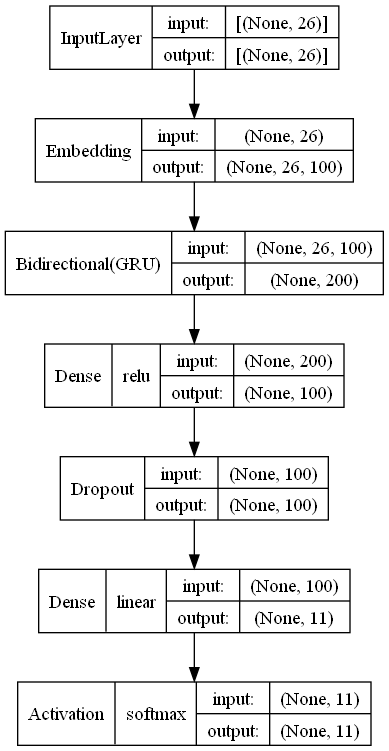

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='GRU_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)


In [22]:
model.save("GRU_Model_Final.h5")